In [1]:
import pandas as pd
from utils import CLASS_DICT
from dataclasses import dataclass
from typing import List
import json 
path1 = "./annotations/labels_my-project-name_2023-02-22-04-13-57.csv"
path2 = "./annotations/labels_my-project-name_2023-02-22-04-39-18.csv"

In [2]:
REVERSED_CLASS_DICT = {v: k for k, v in CLASS_DICT.items()}
ROOT_PATH = "dataset_21_02/"

In [3]:
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
df = pd.concat([df1, df2])
df.head()
df.reset_index(inplace=True)

In [4]:
@dataclass
class Annotation:
    id:int
    iscrowd:int
    image_id:int
    category_id:int
    bbox:List[int]
    area:int
    
    def to_dict(self):
        return {
            "id": self.id,
            "iscrowd": self.iscrowd,
            "image_id": self.image_id,
            "category_id": self.category_id,
            "bbox": self.bbox,
            "area": self.area
        }
    
    
@dataclass
class Image:
    id : int
    width : int
    height : int
    file_name:str
    
    def to_dict(self):
        return {
            "id": self.id,
            "width": self.width,
            "height": self.height,
            "file_name": self.file_name
        }
        
@dataclass
class Category:
    id: int
    name: str
    
    def to_dict(self):
        return {
            "id": self.id,
            "name": self.name
        }

In [5]:
json_data = {
    "info" : {
        "description": "This is a custom dataset",
    },
    "images" : [],
    "annotations" : [],
    "categories" : []
}

In [6]:
start_id = 1000
im_idx = start_id
ann_idx = start_id
for idx, row in df.iterrows():
    image = Image(
        id = im_idx,
        width = row.image_width,
        height= row.image_height,
        file_name=row.image_name
    )
    if row.image_name not in [image["file_name"] for image in json_data["images"]]:
        json_data["images"].append(image.to_dict())
        im_idx += 1
        
for idx, row in df.iterrows():
    image_id = [image["id"] for image in json_data["images"] if image["file_name"] == row.image_name]
    if len(image_id) > 1:
        print("More than one image id ", idx)
    image_id = image_id[0]
    annotation = Annotation(
        id = ann_idx,
        iscrowd=0,
        image_id=image_id,
        category_id=REVERSED_CLASS_DICT[row.label_name],
        bbox=[row.bbox_x, row.bbox_y, row.bbox_width, row.bbox_height],
        area=row.bbox_width * row.bbox_height
    )
    json_data["annotations"].append(annotation.to_dict())
    ann_idx += 1
    
for key, value in CLASS_DICT.items():
    category = Category(id = key, name = value)
    json_data["categories"].append(category.to_dict())

for image in json_data["images"]:
    image["file_name"] = ROOT_PATH + image["file_name"]

print(len(json_data["images"]))
print(len(json_data["annotations"]))
print(len(json_data["categories"]))

202
668
9


In [7]:
json.dump(json_data, open("./annotations/new_dataset_21_02.json", "w"),ensure_ascii=False, indent="\t")

2
./data/dataset_21_02/dp_img2023_02_21_21_29_57_816980%.jpeg


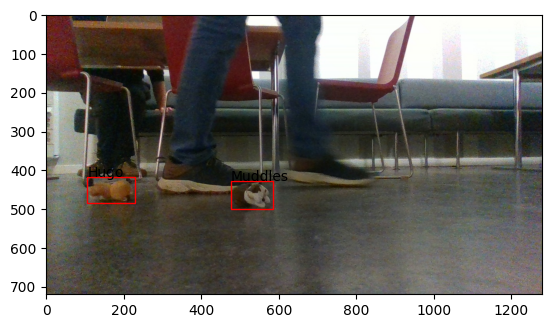

In [52]:
from utils import add_bounding_boxes as add_bbs
import random
import matplotlib.pyplot as plt
from PIL import Image
image = random.choice(json_data["images"])
image_path = "./data/"+ image["file_name"]
annotations = [annotation for annotation in json_data["annotations"] if annotation["image_id"] == image["id"]]
print(len(annotations))
bbx = [(annotation["bbox"], annotation["category_id"]) for annotation in annotations]
fig, axs = plt.subplots(1, 1)
image_pil = Image.open(image_path)
axs.imshow(image_pil)
bb_dicts = [{
    "x": bb[0],
    "y": bb[1],
    "width": bb[2],
    "height": bb[3],
    "category_id": cat
    
} for bb, cat in bbx]
add_bbs(axs, bb_dicts, category_dict=CLASS_DICT)
print(image_path)
plt.show()
